# **Assignment 3 - Pattern Recogonition Course**

## Speech Emotion Recogonition

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torch.serialization import location_tag
base = '/content/drive/MyDrive/Pattern Recognition/Assignment 3/'
!ls '/content/drive/MyDrive/Pattern Recognition/Assignment 3/'


 Crema.zip	      my_model_1.ckpt   my_model.ckpt
 data		      my_model_2.ckpt   PR_Assignment_3_Spring_2023.pdf
 lightning_logs       my_model_3.ckpt  'Speech Emotion Detection.ipynb'
 model_updated.ckpt   my_model_4.ckpt  'speech-emotion-recogonition 2.ipynb'


## Unzipping Data (Do not run it)

In [ ]:
# !unzip '/content/drive/MyDrive/Pattern Recognition/Assignment 3/Crema.zip' -d '/content/drive/MyDrive/Pattern Recognition/Assignment 3/' -q

## Libraries to be imported

In [3]:
!pip install pytorch-lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.6 MB/s eta 0:00:00


In [4]:
import os
import wave
import numpy as np
import pandas as pd
import sys
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

from torch.optim import SGD, Adam
from torchvision import models
from torch.utils.data import DataLoader
from scipy.io.wavfile import read
from sklearn.model_selection import train_test_split
from IPython.display import Audio, display
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS
from torch.utils.data.dataset import TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import pytorch_lightning as pl
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Download the Dataset and Understand the Format (10 Points)
### a. We will use CREMA dataset that is available at the following link: 
https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en

#### Constants

In [6]:
'''
- SAD - sadness;
- ANG - angry;
- DIS - disgust;
- FEA - fear;
- HAP - happy;
- NEU - neutral.
'''
labels_map = {
    "SAD":0,
    "ANG":1,
    "DIS":2,
    "FEA":3,
    "HAP":4,
    "NEU":5
}
labels = ['SAD','ANG','DIS','FEA','HAP','NEU']
audios = []

#ABS_DATASET_LOCATION = base + 'data'
ABS_DATASET_LOCATION = '/content/drive/MyDrive/Pattern Recognition/Assignment 3/data'

#### Reading Audio files

In [7]:
for dirname, _, filenames in os.walk(ABS_DATASET_LOCATION):
    for filename in filenames:
        file = {}
        wav_file_name = str(os.path.join(dirname, filename))
        file['name'] = filename
        file['abs_path'] = wav_file_name
        # Get the emotion type from the name of the wave file
        real_label = wav_file_name.split('_')[2] # ANG SAD
        file['real_label'] = real_label # ANG/SAD/DIS/FEA...
        file['label'] = labels_map[real_label]
        # loading .wav file
        waveform, sample_rate = librosa.load(wav_file_name)
        file['sample_rate'] = sample_rate
        file['wav'] = waveform

        audios.append(file)

### b. Write your own function that loads an audio and listen to each of the classes you have and plot the waveform of the audio. 

In [ ]:
def plot_audio_time_domain(audio):
    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, len(audio['wav'])/audio['sample_rate'], num=len(audio['wav'])), audio['wav'])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Audio file in time domain for class {audio["real_label"]}')
    plt.show()

In [ ]:
features = list(labels_map.keys())

features = np.array(features)

random_picks = []
for feature in features:
    feature_indices = np.where(features == feature)
    random = np.random.choice(list(feature_indices)[0])
    random_picks.append(random)
    print("The waveform of random class {0}".format(feature))
    plot_audio_time_domain(audios[random])

#### Playing audios from different classes

In [ ]:
for r in random_picks:
    print(f"Audio for class [{audios[r]['real_label']}]")
    display(Audio(data=audios[r]['wav'], rate = audios[r]['sample_rate'], autoplay=False))

## 2. Creating the Feature Space (30 Points) 
#### a. You can work on time domain, or you can work in frequency domain. There are multiple of features that can help improving the model:

In [ ]:
# Calculate the zero crossing rate
zcr_energy = np.empty((1,2))
for audio in audios:
        zcr_datapoint = np.count_nonzero(np.diff(audio['wav']) != 0)
        energy_datapoint = np.mean(np.linalg.norm(audio['wav']) ** 2)
        zcr_energy = np.vstack((zcr_energy, np.array([zcr_datapoint,energy_datapoint])))
        audio['zcr_energy'] = zcr_energy[1:]

#### b. Convert the audio waveform to mel spectrogram and use this as the feature space.

In [8]:
max_padding = 216
for audio in audios:
    mel_spectrogram = librosa.feature.melspectrogram(y=audio['wav'], sr=audio['sample_rate'],n_mels=128)
    padding = ((0, 0), (0, max_padding - mel_spectrogram.shape[1]))
    audio['mel'] = torch.from_numpy(np.pad(mel_spectrogram,padding))
    

In [ ]:
print(audio['mel'].shape)

torch.Size([128, 216])


# 3. Building Model 

## a. Split the data into 70% training and validation and 30% testing.
## b. Use 5% of the training and validation data for validation.


In [9]:
# assuming 'audios' is the list of dictionaries containing your data
features = [audio['label'] for audio in audios]

# split data into training and testing sets, stratifying by labels
train_val_audios, test_audios, train_val_labels, test_labels = train_test_split(
    audios, features, test_size=0.3, random_state=42, stratify=features)

# split training and validation sets, stratifying by labels
train_audios, val_audios, train_labels, val_labels = train_test_split(
    train_val_audios, train_val_labels, test_size=0.05, random_state=42, 
    stratify=train_val_labels)

print("Size of training data:", len(train_val_audios))
print("Size of testing data:", len(test_audios))
print("Size of validating data:", len(val_audios))  

Size of training data: 5209
Size of testing data: 2233
Size of validating data: 261


## CNN Model

In [10]:
hyper_parameters = {
    'num_mel_bins':128,
    'lr':5.248074602497726e-05,
    'num_classes':6
}

In [19]:
from math import nan
from torch.nn import functional as F
class LightningModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.num_classes = hyper_parameters['num_classes']
        self.num_mel_bins = hyper_parameters['num_mel_bins']
        self.lr = hyper_parameters['lr']
        

        self.conv1 = torch.nn.Conv2d(1, 512, kernel_size=5, stride=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=5, stride=2)

        self.conv2 = torch.nn.Conv2d(512, 512, kernel_size=5, stride=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=5, stride=2)

        self.conv3 = torch.nn.Conv2d(512, 128, kernel_size=5, stride=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=5, stride=2)

        self.fc1 = torch.nn.Linear(23040, 265)
        self.relu4 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(265, self.num_classes)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        #print(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #print(y_hat)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True)
        return loss

### Model Training

In [12]:
processed_data = []
for audio in train_val_audios:
    processed_data.append(audio['mel'])
inputs = torch.stack(processed_data,axis=0).unsqueeze(1)
labels = torch.tensor(train_val_labels)
dataset = TensorDataset(inputs,labels)
dataloader = DataLoader(dataset)

processed_data = []
for audio in val_audios:
    processed_data.append(audio['mel'])
inputs_val = torch.stack(processed_data,axis=0).unsqueeze(1)
labels_val = torch.tensor(val_labels)
dataset = TensorDataset(inputs_val,labels_val)
validation_dataloader = DataLoader(dataset)

processed_data = []
for audio in test_audios:
    processed_data.append(audio['mel'])
inputs_test = torch.stack(processed_data,axis=0).unsqueeze(1)
labels_test = torch.tensor(test_labels)
dataset = TensorDataset(inputs_test,labels_test)
testing_dataloader = DataLoader(dataset)

In [13]:
print(inputs.shape)
print(inputs[0].shape)
print(len(train_val_audios))

torch.Size([5209, 1, 128, 216])
torch.Size([1, 128, 216])
5209


### New Training

In [ ]:
trainer = pl.Trainer(max_epochs=10,default_root_dir=base)
model = LightningModel()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
tuner = pl.tuner.tuning.Tuner(trainer)

lr_find_results = tuner.lr_find(
    model,
    train_dataloaders=dataloader,
    val_dataloaders=validation_dataloader,
    min_lr=1e-6,
    max_lr=1e-4,
    early_stop_threshold=None
)

new_lr = lr_find_results.suggestion();
print("Suggested learning_rate " + str(new_lr))

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 5.248074602497726e-05
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pattern Recognition/Assignment 3/.lr_find_2d1dfc6d-e351-4fa0-be1d-759bbefdc8b4.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/drive/MyDrive/Pattern Recognition/Assignment 3/.lr_find_2d1dfc6d-e351-4fa0-be1d-759bbefdc8b4.ckpt


Suggested learning_rate 5.248074602497726e-05


#### Run next cell if you accepted the suggested learning rate

In [ ]:
model.lr = new_lr

In [ ]:
trainer.fit(model,train_dataloaders=dataloader, val_dataloaders=validation_dataloader)

### Resume Training

In [22]:
trainer = pl.Trainer(max_epochs=110,default_root_dir=base)
model = LightningModel()

# automatically restores model, epoch, step, LR schedulers, etc..
trainer.fit(model,train_dataloaders=dataloader,val_dataloaders=validation_dataloader ,ckpt_path= base + "/lightning_logs/version_3/checkpoints/epoch=108-step=567781.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pattern Recognition/Assignment 3//lightning_logs/version_3/checkpoints/epoch=108-step=567781.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/content/lightning_logs/version_0/checkpoints' to '/content/drive/MyDrive/Pattern Recognition/Assignment 3/lightning_logs/version_7/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
INFO

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=110` reached.


### Saving Model

In [23]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Pattern Recognition/Assignment 3/model_100_epochs.ckpt")

### load old model

In [21]:
model = LightningModel()
model.load_state_dict(torch.load(base + "/lightning_logs/version_3/checkpoints/epoch=108-step=567781.ckpt"))

RuntimeError: ignored

## Model validation and testing

### Validation and Testing

In [ ]:
trainer.validate(model=model,dataloaders=validation_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      val_loss_epoch       │    1.6187236309051514     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 1.6187236309051514}]

In [ ]:
trainer.test(model=model,dataloaders=testing_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    1.7560514211654663     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.7560514211654663}]

In [24]:
device = torch.device('cuda')

def eval_acc(model, device, dataloader, debug_name=None):
    model = model.to(device).eval()
    count = correct = 0
    for X, gt in dataloader:
        logits = model(X.to(device))
        preds = torch.argmax(logits, dim=1)
        correct += sum(preds.cpu() == gt)
        count += len(gt)
    acc = correct/count
    if debug_name:
        print(f'{debug_name} acc = {acc:.4f}')
    return acc

In [25]:
eval_acc(trainer.model, device, validation_dataloader, 'val')
eval_acc(trainer.model, device, testing_dataloader, 'test')

val acc = 0.6743
test acc = 0.4778


In [26]:
predictions = trainer.predict(model=model,dataloaders=testing_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [27]:
predicated_labels = [predication.argmax().item() for predication in predictions]

In [28]:
# Function to calculate the precision, recall and F1 score
def get_precision_recall_f1_score(k, y_pred, y_true):
    # check if y_pred and y_true are a numpy array
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    P = np.zeros(k)
    R = np.zeros(k)
    F = np.zeros(k)
    
    for i in range(k):
        # get indices of points in cluster i
        indices = np.where(y_pred == i)
        if len(indices[0]) == 0:
          continue
        # get the most frequent label in cluster i
        most_frequent_label = np.bincount(y_true[indices]).argmax()
        # get the number of points in cluster i that have the most frequent label
        number_of_points = np.sum(y_true[indices] == most_frequent_label)
        
        # get the number of points in cluster i
        number_of_points_in_cluster = len(indices[0])
        # Precision P = TP / (TP + FP)
        P[i] = number_of_points / number_of_points_in_cluster
        
        # get the number of points that have the most frequent label
        number_of_points_with_most_frequent_label = np.sum(
            y_true == most_frequent_label)
        # Recall R = TP / (TP + FN)
        R[i] = number_of_points / number_of_points_with_most_frequent_label
        
        # F1 score = 2 * P * R / (P + R)
        F[i] = 2 * P[i] * R[i] / (P[i] + R[i])
        
    # Average F1 score
    # F = np.mean(F)
    
    return P, R, F


In [29]:
_, _, F = get_precision_recall_f1_score(6, predicated_labels, test_labels)
print(F.mean())

0.4799608165549308


### Confusion Matrix

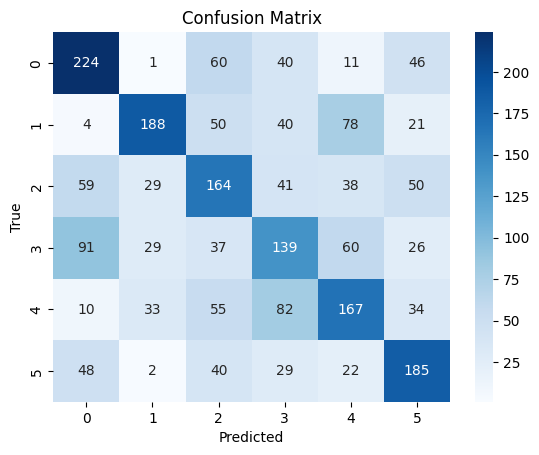

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Get the true labels and predicted labels.
true_labels = np.array(test_labels)
predicted_labels = np.array(predicated_labels)

# Get the class names.
class_names = list(set(true_labels))

# Plot the confusion matrix.
confusion_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure()
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()